### EMPIAR-11969 TEST

In [1]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

import odl

#### Load Tilt-Series

In [2]:

path = "/mnt/c/Users/adamh/OneDrive/Dokument/KTH/TTMAM/MEX/data/EMPIAR-11969/aligned/TiltSeries/EMPIAR_11969_aligned.mrcs"

with mrcfile.open(path, permissive=True) as mrc:
    stack = mrc.data.copy()
    
print("shape:", stack.shape)
print("dtype:", stack.dtype)
print("min / max:", stack.min(), stack.max())

shape: (41, 5760, 4092)
dtype: float32
min / max: -0.557716 256.211


#### Load Metadata

In [3]:
meta_path = Path("/mnt/c/Users/adamh/OneDrive/Dokument/KTH/TTMAM/MEX/data/EMPIAR-11969/metadata/EMPIAR-11969_api.json")

meta = json.loads(meta_path.read_text(encoding="utf-8"))
print(type(meta))
print(list(meta.keys())[:20])

<class 'dict'>
['EMPIAR-11969']


**Note.** The aligned tilt series was produced using IMOD/etomo.  
IMOD outputs aligned stacks in monotonic tilt-angle order, so the projections are assumed to be ordered from −60° to +60° (41 angles, 3° step).


In [4]:
n_tilts = 41  # from your stack shape
angles_deg = np.linspace(-60, 60, n_tilts)   # -60, -57, ..., 57, 60
angles = np.deg2rad(angles_deg)
angle_partition = odl.nonuniform_partition(angles)


#### Bin detectors to reduce memory

In [5]:
import gc
def bin2d_mean(arr, by=4):
    # arr: (n, Ny, Nx)
    n, Ny, Nx = arr.shape
    Ny2 = (Ny // by) * by
    Nx2 = (Nx // by) * by
    a = arr[:, :Ny2, :Nx2]
    a = a.reshape(n, Ny2//by, by, Nx2//by, by).mean(axis=(2,4))
    return a

bin_factor = 4
stack_binned = bin2d_mean(stack, by=bin_factor).astype(np.float32, copy=False)
print("Binned stack:", stack_binned.shape, stack_binned.dtype)


# normalization (recommended for cryo-ET FBP)
# Remove per-tilt DC offset and normalize per-tilt contrast.
m = stack_binned.mean(axis=(1, 2), keepdims=True)
# s = stack_binned.std(axis=(1, 2), keepdims=True)
# stack_binned = (stack_binned - m) / (s + 1e-6)
stack_binned = stack_binned - m

# Ensure contiguous memory for ASTRA (avoids crashes / slowdowns)
stack_binned = np.ascontiguousarray(stack_binned)

print("After norm: mean/std (first tilt):",
      float(stack_binned[0].mean()), float(stack_binned[0].std()))

# Optional if contrast is inverted compared to reference
# stack_binned = -stack_binned

del stack
gc.collect()

Binned stack: (41, 1440, 1023) float32
After norm: mean/std (first tilt): -1.7733806089381687e-05 7.052380561828613


26

**2D detector partition**: From metadata

In [6]:
px = 2.075 * bin_factor  # Å
py = 2.075 * bin_factor  # Å

Ny, Nx = stack_binned.shape[1:]  # 5760/4, 4092/4

print(f"Nx = {Nx}, Ny = {Ny}")


det_partition = odl.uniform_partition(
    min_pt=[-(Nx/2)*px, -(Ny/2)*py], 
    max_pt=[(Nx/2)*px, (Ny/2)*py],
    shape=[Nx, Ny]
)


Nx = 1023, Ny = 1440


**Parallel-beam 3D geometry**

In [7]:
geometry = odl.tomo.geometry.parallel.Parallel3dAxisGeometry(
    apart=angle_partition,
    dpart=det_partition,
    axis= (0,1,0)
)

In [8]:
# choose reconstruction volume (matches the reference size)
Nx_rec, Ny_rec, Nz_rec = 1023, 1440, 375
fov_x, fov_y, fov_z = (Nx/2)*px, (Ny/2)*py, (Nz_rec/2) * px

reco_space = odl.uniform_discr(
    [-fov_x, -fov_y, -fov_z],
    [ fov_x,  fov_y,  fov_z],
    [Nx_rec, Ny_rec, Nz_rec],
    dtype=np.float32
)

# 3D ray transform
raytrafo = odl.tomo.RayTransform(vol_space=reco_space, 
                                 geometry=geometry, 
                                 impl="astra_cuda")

dataspace = raytrafo.range
stack_binned = stack_binned.transpose(0, 2, 1)

print("A.range.shape =", dataspace.shape)
print("stack.shape   =", stack_binned.shape)

A.range.shape = (41, 1023, 1440)
stack.shape   = (41, 1023, 1440)


In [9]:

# Filtered backprojection
# Availible filters: 'Ram-Lak', 'Shepp-Logan', 'Cosine', 'Hamming', 'Hann'
fbp = odl.tomo.fbp_op(ray_trafo=raytrafo, filter_type="Shepp-Logan")

data = dataspace.element(stack_binned)

reco = fbp(data)

/home/ahopkins/KTH_TTMAM/MEX/odl_xray/venv/lib/python3.10/site-packages/odl/util/utility.py:1398: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_requirements


In [10]:
# Remove large objects no longer needed (avoid kernel crash)

import gc
del stack_binned
del data
del fbp
del raytrafo

gc.collect()

49

In [11]:
ref_path = Path("/mnt/c/Users/adamh/OneDrive/Dokument/KTH/TTMAM/MEX/data/EMPIAR-11969/recon_ref/EMPIAR_11969_recon.mrc")

slice_axis = 0  # (Nz, Ny, Nx)

# --- your reco -> numpy view in (Nz,Ny,Nx) ---
reco_np = np.asarray(reco, dtype=np.float32)
reco_view = reco_np.transpose(2, 1, 0)  # (Nz, Ny, Nx)  <-- use this for slicing!
reco_match = reco_view[::-1, :, :]  # reverse z-axis for reference match

print("reco_np shape:", reco_np.shape)
print("reco_match shape:", reco_match.shape)

# helper: extract slice without copying unnecessarily
def get_slice(vol, axis, k):
    return np.take(vol, k, axis=axis).astype(np.float32, copy=False)

# --- open reference with mmap (no full load) ---
with mrcfile.mmap(ref_path, permissive=True) as mrc:
    ref = mrc.data  # memmap-backed
    print("Ref shape (no full load):", ref.shape, ref.dtype)

    # If these don't match, stop early (means wrong transpose / axis choice)
    assert reco_match.shape == ref.shape, "Shapes differ: check transpose/axis."

    Nz = reco_match.shape[slice_axis]
    idxs = [int(0.40*(Nz-1)), int(0.50*(Nz-1)), int(0.60*(Nz-1))]

    slices_you = [get_slice(reco_match, slice_axis, k) for k in idxs]
    slices_ref = [get_slice(ref,        slice_axis, k) for k in idxs]


reco_np shape: (1023, 1440, 375)
reco_match shape: (375, 1440, 1023)
Ref shape (no full load): (375, 1440, 1023) int16


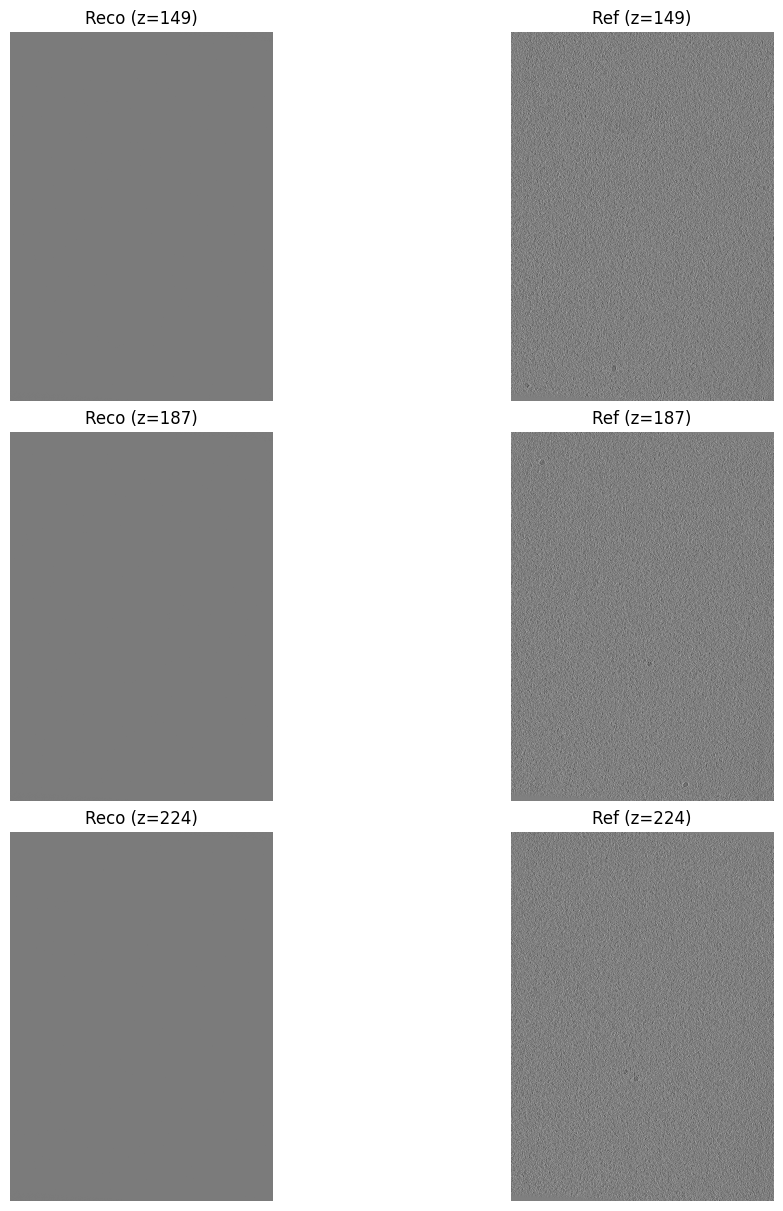

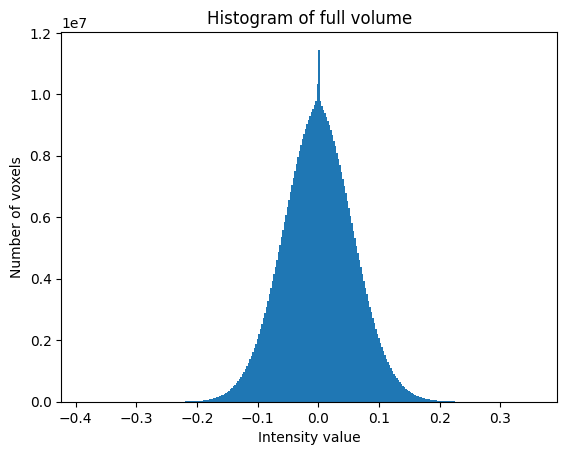

In [12]:

# robust scaling per-volume using only sampled slices
def robust_scale_from_slices(slices, lo=1, hi=99):
    vals = np.concatenate([s.ravel() for s in slices])
    return float(np.percentile(vals, lo)), float(np.percentile(vals, hi))

# shared scale from both volumes sampled slices
vals_both = np.concatenate([s.ravel() for s in slices_you + slices_ref])
vmin = float(np.percentile(vals_both, 5))
vmax = float(np.percentile(vals_both, 95))


fig, axes = plt.subplots(3, 2, figsize=(10, 12), constrained_layout=True)
for r, k in enumerate(idxs):
    axes[r, 0].imshow(slices_you[r], cmap="gray", vmin=vmin, vmax=vmax)
    axes[r, 0].set_title(f"Reco (z={k})")
    axes[r, 0].axis("off")

    axes[r, 1].imshow(slices_ref[r], cmap="gray", vmin=vmin, vmax=vmax)
    axes[r, 1].set_title(f"Ref (z={k})")
    axes[r, 1].axis("off")

plt.show()

plt.figure()
plt.hist(reco_match.ravel(), bins=300)
plt.xlabel("Intensity value")
plt.ylabel("Number of voxels")
plt.title("Histogram of full volume")
plt.show()


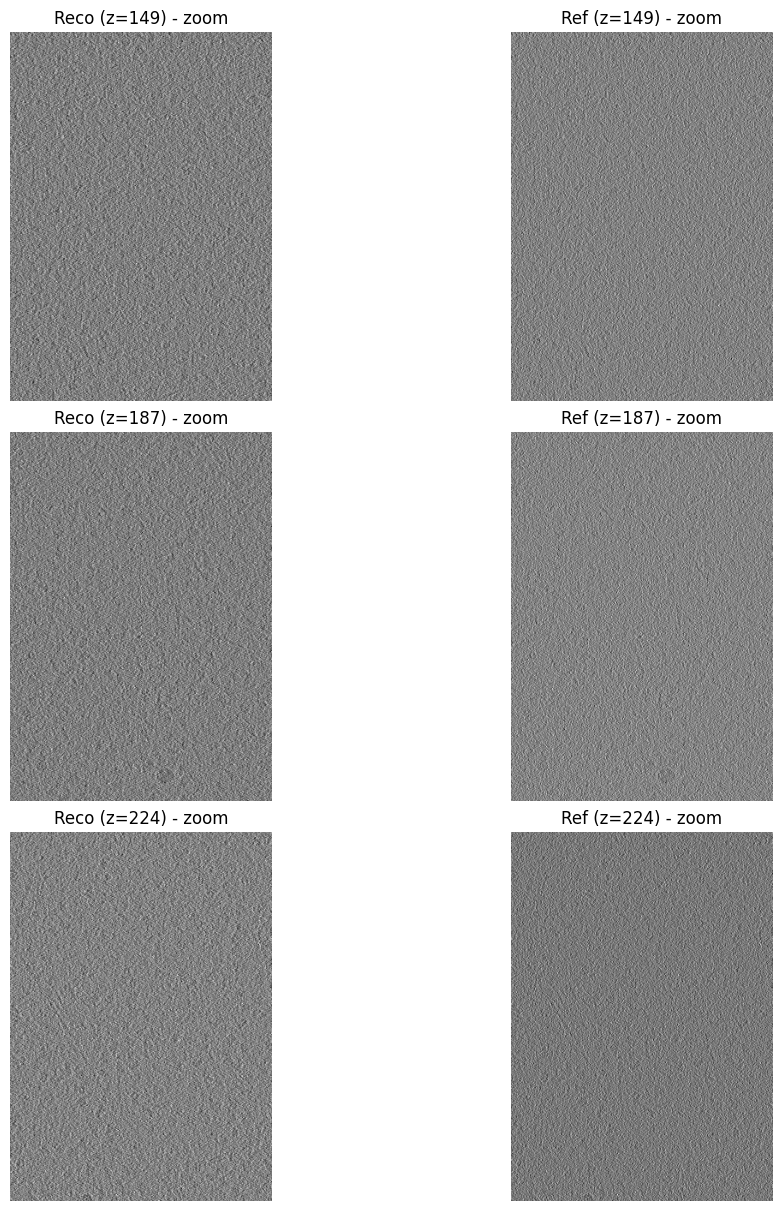

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12), constrained_layout=True)

Ny = reco_match.shape[1]
Nx = reco_match.shape[2]

frac = 0.30  # 20%

h = int(frac * Ny / 2)
w = int(frac * Nx / 2)

yc = Ny // 2
xc = Nx // 2

y0, y1 = yc - h, yc + h
x0, x1 = xc - w, xc + w

for r, k in enumerate(idxs):
    axes[r, 0].imshow(
        slices_you[r][y0:y1, x0:x1],
        cmap="gray"#, vmin=vmin, vmax=vmax
    )
    axes[r, 0].set_title(f"Reco (z={k}) - zoom")
    axes[r, 0].axis("off")

    axes[r, 1].imshow(
        slices_ref[r][y0:y1, x0:x1],
        cmap="gray"#, vmin=vmin, vmax=vmax
    )
    axes[r, 1].set_title(f"Ref (z={k}) - zoom")
    axes[r, 1].axis("off")

plt.show()


In [14]:
import numpy as np

def corr2(a, b):
    a = a.astype(np.float32).ravel()
    b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    return float((a @ b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-12))

def best_orient_corr(you, ref):
    # try common 2D orientation fixes
    cands = {
        "none": lambda x: x,
        "flipud": np.flipud,
        "fliplr": np.fliplr,
        "flipud+fliplr": lambda x: np.flipud(np.fliplr(x)),
        "transpose": lambda x: x.T,
        "transpose+flipud": lambda x: np.flipud(x.T),
        "transpose+fliplr": lambda x: np.fliplr(x.T),
        "transpose+flipud+fliplr": lambda x: np.flipud(np.fliplr(x.T)),
    }
    best = None
    for name, f in cands.items():
        y = f(you)
        if y.shape != ref.shape:
            continue
        c = corr2(y, ref)
        if (best is None) or (c > best[0]):
            best = (c, name)
    return best

# pick a representative z-slice
k = reco_match.shape[0] // 2
you_sl = reco_match[k]
ref_sl = np.asarray(ref[k], dtype=np.float32)   # same k

print("Shapes:", you_sl.shape, ref_sl.shape)

print("Best corr + transform:", best_orient_corr(you_sl, ref_sl))
print("If transform = none, the used orientation is likely the correct one")



Shapes: (1440, 1023) (1440, 1023)
Best corr + transform: (0.7309901714324951, 'none')
If transform = none, the used orientation is likely the correct one


In [15]:
import numpy as np

Nz = reco_match.shape[0]
zs = np.linspace(0, Nz-1, 20).astype(int)

cors = []
for k in zs:
    c = corr2(reco_match[k], np.asarray(ref[k], dtype=np.float32))
    cors.append(c)

print(" z-slice | correlation")
print("----------------------")
for z, c in zip(zs, np.round(cors, 3)):
    print(f"{z:7d} | {c:11.3f}")

print("----------------------")
print(f" mean   | {np.mean(cors):11.3f}")


 z-slice | correlation
----------------------
      0 |       0.729
     19 |       0.732
     39 |       0.732
     59 |       0.733
     78 |       0.733
     98 |       0.733
    118 |       0.736
    137 |       0.736
    157 |       0.734
    177 |       0.734
    196 |       0.734
    216 |       0.735
    236 |       0.734
    255 |       0.735
    275 |       0.736
    295 |       0.734
    314 |       0.733
    334 |       0.733
    354 |       0.732
    374 |       0.729
----------------------
 mean   |       0.733
